In [63]:
from google.colab import files
from os.path import exists
from os import environ, system

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.cluster import KMeans

# load dataset
uploaded = files.upload()

for filename in uploaded.keys():
  df = pd.read_csv(filename)
  break

Saving Telco-Customer-Churn_Kaggle.csv to Telco-Customer-Churn_Kaggle (3).csv


In [64]:
# based on the information in the csv there should be 17 strings and 2 integers and 2 floats
# running a quick summary to check for correct data types displayed and if there are any missing values
print("Data types and missing values: ")
print(df.info())

Data types and missing values: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessB

The summary shows that monthly charges is recognised as an object (string) instead of a float (numeric). It is most likely stored as a string due to some missing or blank values

We will convert it to numeric using pd.to_numeric and set errors='coerce' to mark errors as NaN and then we will drop NaN values

In [65]:
# Convert TotalCharges to numeric, mark errors as NaN
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Drop rows where TotalCharges is NaN
df = df.dropna(subset=['TotalCharges'])

**1.0 Data Preprocessing**

In [66]:
# Checking for the type and content of df before dropping the column
print(f"Type of df before dropping customerID: {type(df)}")
print("First 5 rows of df before dropping customerID:")
display(df.head())

Type of df before dropping customerID: <class 'pandas.core.frame.DataFrame'>
First 5 rows of df before dropping customerID:


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [67]:
df = df.drop('customerID', axis=1)
# just a unique identifier and provides no useful predictive value

In [68]:
# Checking for the type and content of df after dropping the column
print(f"Type of df before after customerID: {type(df)}")
print("First 5 rows of df after dropping customerID:")
display(df.head())

Type of df before after customerID: <class 'pandas.core.frame.DataFrame'>
First 5 rows of df after dropping customerID:


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [69]:
# 1.1
# Label Encoding: encode target label 'Churn'
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

# Encode binary categorical features
binary_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']
for col in binary_cols:
    df[col] = df[col].map({'Yes': 1, 'No': 0, 'Female': 0, 'Male': 1})

# 1.2
# One-hot Encoding: encode other categorical columns
multi_cat_cols = ['MultipleLines', 'InternetService', 'OnlineSecurity',
                  'OnlineBackup', 'DeviceProtection', 'TechSupport',
                  'StreamingTV', 'StreamingMovies', 'Contract',
                  'PaymentMethod']
df = pd.get_dummies(df, columns=multi_cat_cols)

# 1.3
# Bin 'tenure' into categories: Short (1–12), Medium (13–48), Long (49+)
df['tenure_group'] = pd.cut(
    df['tenure'],
    bins=[0, 12, 48, df['tenure'].max()],
    labels=['Short', 'Medium', 'Long'],
    include_lowest=True
)

# One-hot encode the binned tenure group
df = pd.get_dummies(df, columns=['tenure_group'])

# **Objective 1: Identify key attributes associated with churn**


🔍 Top 10 Features Most Associated with Churn (Random Forest Importance):
TotalCharges                      0.204484
MonthlyCharges                    0.172099
Contract_Month-to-month           0.051095
tenure_group_Short                0.033399
OnlineSecurity_No                 0.032262
gender                            0.031304
TechSupport_No                    0.031215
InternetService_Fiber optic       0.027933
PaymentMethod_Electronic check    0.027028
Partner                           0.026376
dtype: float64


<ipython-input-74-d16d9e8a75ff>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importance.head(10), y=feature_importance.head(10).index, palette="viridis")


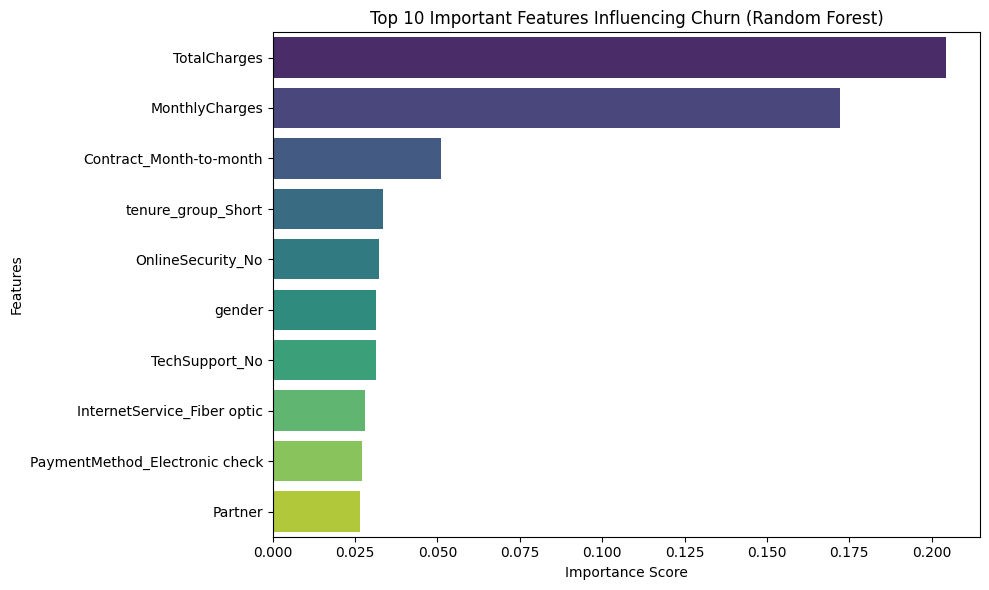

In [74]:
# Drop original 'tenure' column BEFORE defining X
df = df.drop(columns=['tenure'])

# Define features (X) and target (y)
# The target is 'Churn', so all other columns are features
X = df.drop('Churn', axis=1)
y = df['Churn']

# Instantiate and train the Random Forest Classification Model
# Use a random state for reproducibility
rf_model = RandomForestClassifier(n_estimators=100, random_state=42) # Added n_estimators for clarity
rf_model.fit(X, y) # Train the model on the entire dataset

# Random Forest Classification Model
feature_importance = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)

print("\n🔍 Top 10 Features Most Associated with Churn (Random Forest Importance):")
print(feature_importance.head(10))

# Optional plot of feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance.head(10), y=feature_importance.head(10).index, palette="viridis")
plt.title("Top 10 Important Features Influencing Churn (Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

Using the data mining technique of Random Forest Classification Model,  we can see that the feature 'Total Charges' is most likely attribute to customer churn, followed by  'Monthly Charges' and close third of contract_month-to-month

# **Objective 2: Determine which combination of services are linked to higher churn**

The output form the Random Forest Classification Model has identified these features linked to the telcom's provided service as most attributed to churn: 'Monthly Charges', 'Contract_Month-to-Month', 'TechSupport_No', 'OnlineSecurity_No' and 'InternetService_Fiber optic'.

As these are the features likely to be the cause for churn, we will determing which combination of these services are linked to highest churn.

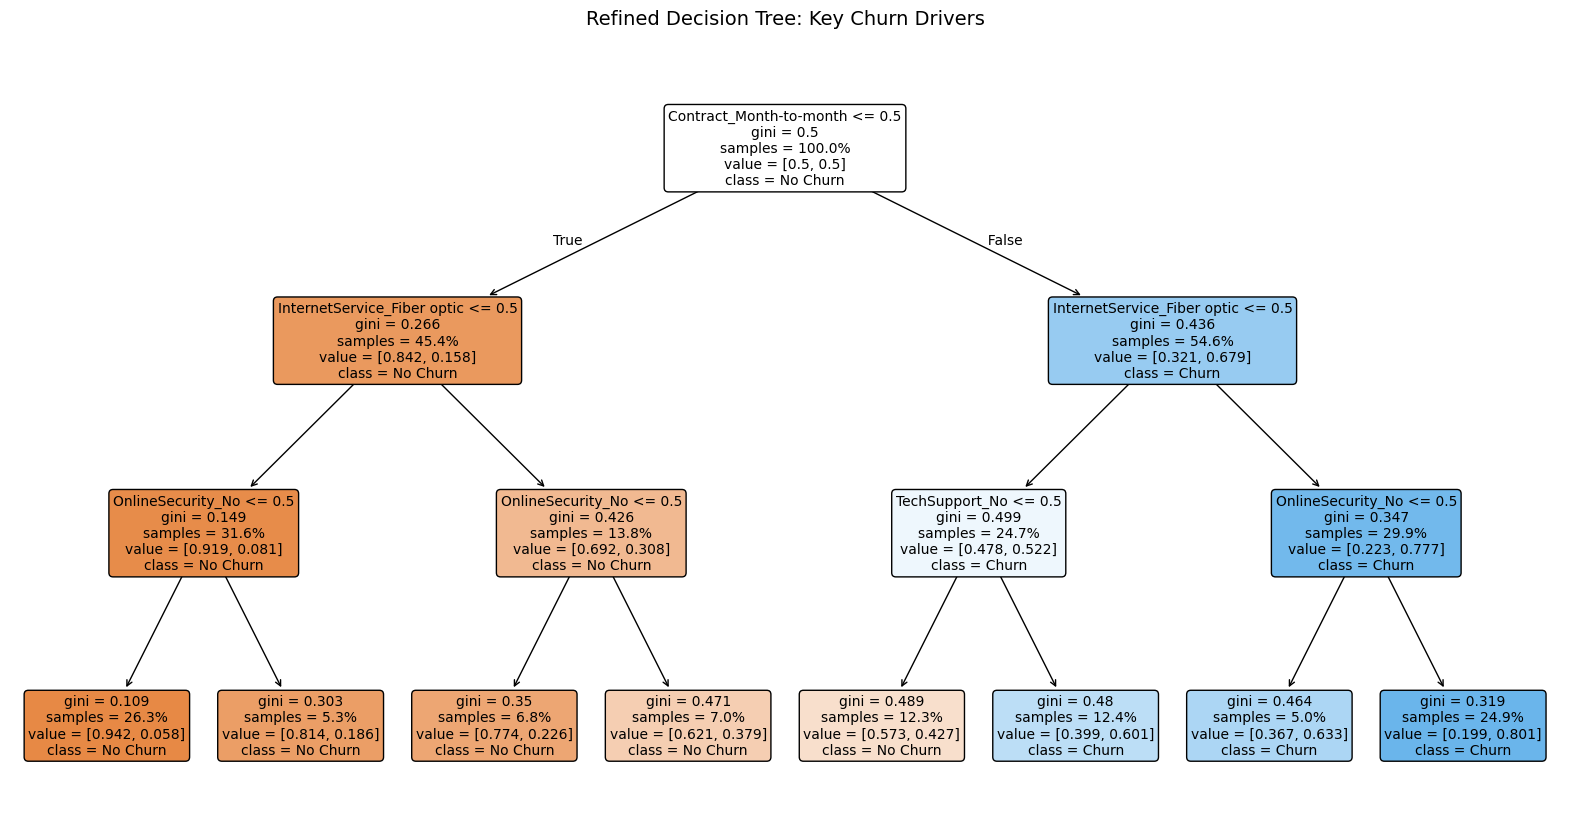


=== Model Evaluation ===
              precision    recall  f1-score   support

           0       0.90      0.69      0.78      1549
           1       0.48      0.79      0.59       561

    accuracy                           0.71      2110
   macro avg       0.69      0.74      0.69      2110
weighted avg       0.79      0.71      0.73      2110


=== Feature Importance ===
OnlineSecurity_No: 3.26%
TechSupport_No: 2.38%
InternetService_Fiber optic: 17.65%
Contract_Month-to-month: 76.70%
PaymentMethod_Electronic check: 0.00%
PaperlessBilling: 0.00%

=== Churn Rate by Segment ===
 Contract_Month-to-month  InternetService_Fiber optic  OnlineSecurity_No  TechSupport_No    Churn
                    True                         True               True            True 0.606955
                    True                         True               True           False 0.424000
                    True                        False               True            True 0.405616
                   

In [79]:
selected_features = [
    'OnlineSecurity_No',
    'TechSupport_No',
    'InternetService_Fiber optic',
    'Contract_Month-to-month',
    'PaymentMethod_Electronic check',
    'PaperlessBilling',       # Binary-encoded
]

# Prepare data
X = df[selected_features]
y = df['Churn']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Train decision tree
dt_model = DecisionTreeClassifier(
    max_depth=3,
    min_samples_leaf=100,
    class_weight='balanced',
    random_state=42
)
dt_model.fit(X_train, y_train)

# Visualize the tree
plt.figure(figsize=(20,10))
plot_tree(
    dt_model,
    feature_names=selected_features,
    class_names=['No Churn', 'Churn'],
    filled=True,
    proportion=True,
    rounded=True,
    fontsize=10
)
plt.title("Refined Decision Tree: Key Churn Drivers", pad=20, fontsize=14)
plt.show()

# Evaluation
print("\n=== Model Evaluation ===")
y_pred = dt_model.predict(X_test)
print(classification_report(y_test, y_pred))

# Feature importance
print("\n=== Feature Importance ===")
for feature, importance in zip(selected_features, dt_model.feature_importances_):
    print(f"{feature}: {importance:.2%}")

# Segment Analysis Validation
print("\n=== Churn Rate by Segment ===")
segment_results = df.groupby([
    'Contract_Month-to-month',
    'InternetService_Fiber optic',
    'OnlineSecurity_No',
    'TechSupport_No',
])['Churn'].mean().reset_index()

# Format for better readability
print(segment_results.sort_values('Churn', ascending=False).to_string(index=False))


From this Decision Tree Classification Model, we can see that the feature with most importance by a significant value is contract_Month-to-Month followed by InternetService_Fiber optic.  

The combination that results in the highest potential customer churn of 61% is:

IF Contract_Month-to-Month = True

AND InternetServiceProvide_Fiber Optic = TRUE

AND OnlineSecurity = True

AND TechSupport_No = True

Then there is a high risk of churn

# **Objective 3: Segment customers based on churn risks**


In [80]:
# before we segment customers based on churn risk, we must first define churn risk threshholds
overall_churn_rate = df['Churn'].mean()
print(f"Overall churn rate: {overall_churn_rate:.2%}")

# we will define the thresholds as follows:
# very high : > 50% : significanty above average churn rate
# high risk : 35-50% : above average churn rate
# medium risk : 20 - 35% : near or slighlty above average
# low : < 20% : clearly below average


Overall churn rate: 26.58%


In [84]:
# Group and classify segments
grouped = df.groupby([
    'Contract_Month-to-month',
    'InternetService_Fiber optic',
    'OnlineSecurity_No',
    'TechSupport_No'
])['Churn'].agg(['mean', 'count']).reset_index()
grouped.columns = ['Month-to-Month', 'Fiber_Optic', 'No_OnlineSecurity', 'No_TechSupport', 'ChurnRate', 'Segment_Size']

# Risk classification
bins = [0, 0.2, 0.35, 0.5, 1]
labels = ['Low Risk', 'Medium Risk', 'High Risk', 'Very High Risk']
grouped['RiskTier'] = pd.cut(grouped['ChurnRate'], bins=bins, labels=labels)

# Create customer profile descriptions
def describe_segment(row):
    profile = []
    if row['Month-to-Month']: profile.append("Month-to-month contract")
    else: profile.append("Long-term contract")

    if row['Fiber_Optic']: profile.append("Fiber optic internet")
    else: profile.append("Non-fiber internet")

    if row['No_OnlineSecurity']: profile.append("No online security")
    else: profile.append("Has online security")

    if row['No_TechSupport']: profile.append("No tech support")
    else: profile.append("Has tech support")

    return ", ".join(profile)

grouped['Customer_Profile'] = grouped.apply(describe_segment, axis=1)

# Format output tables
pd.set_option('display.max_colwidth', 60)

# 1. Priority Segments (sorted by risk)
priority_segments = grouped[grouped['RiskTier'].isin(['High Risk', 'Very High Risk'])]
priority_segments = priority_segments.sort_values('ChurnRate', ascending=False)

print("=== 🎯 High Priority Customer Segments ===")
print(priority_segments[['Customer_Profile', 'ChurnRate', 'RiskTier', 'Segment_Size']].to_markdown(index=False))

# 2. Full Risk Tier Breakdown
print("\n=== 📊 Complete Risk Tier Classification ===")
full_breakdown = grouped.groupby('RiskTier').agg(
    Avg_ChurnRate=('ChurnRate', 'mean'),
    Total_Customers=('Segment_Size', 'sum'),
    Segment_Count=('Segment_Size', 'count')
).reset_index()

print(full_breakdown.to_markdown(index=False))

# 3. Example Profiles for Each Tier (for visualization)
print("\n=== 👥 Characteristic Profiles by Risk Tier ===")
for tier in labels[::-1]:  # Reverse to show highest risk first
    examples = grouped[grouped['RiskTier'] == tier].head(2)
    print(f"\n🔴 {tier} (Avg Churn: {examples['ChurnRate'].mean():.1%})")
    for _, row in examples.iterrows():
        print(f"- {row['Customer_Profile']} (Churn: {row['ChurnRate']:.1%}, N={row['Segment_Size']})")

=== 🎯 High Priority Customer Segments ===
| Customer_Profile                                                                    |   ChurnRate | RiskTier       |   Segment_Size |
|:------------------------------------------------------------------------------------|------------:|:---------------|---------------:|
| Month-to-month contract, Fiber optic internet, No online security, No tech support  |    0.606955 | Very High Risk |           1524 |
| Month-to-month contract, Fiber optic internet, No online security, Has tech support |    0.424    | High Risk      |            250 |
| Month-to-month contract, Non-fiber internet, No online security, No tech support    |    0.405616 | High Risk      |            641 |
| Month-to-month contract, Fiber optic internet, Has online security, No tech support |    0.397059 | High Risk      |            272 |

=== 📊 Complete Risk Tier Classification ===
| RiskTier       |   Avg_ChurnRate |   Total_Customers |   Segment_Count |
|:---------------|----

<ipython-input-84-84f8252bfc3d>:46: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  full_breakdown = grouped.groupby('RiskTier').agg(
